# **STA395 PROJECT**

***Authors: Minh Nguyen, Nam Do***

# **Libraries**

In [ ]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# Turn off future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.metrics import f1_score, mean_squared_error
from scipy.stats import poisson, uniform
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict

# **Data Processing**

In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
songs = pd.read_csv("/content/drive/MyDrive/songs.csv", encoding='unicode_escape')
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No.          125 non-null    int64  
 1   Language     125 non-null    object 
 2   Region       125 non-null    object 
 3   Tonal        125 non-null    int64  
 4   Song         125 non-null    object 
 5   Genre        125 non-null    object 
 6   Year         125 non-null    int64  
 7   Decade       125 non-null    object 
 8   SD           125 non-null    float64
 9   AvgRollDiff  125 non-null    float64
 10  AvgSD5       125 non-null    float64
 11  AvgSD10      125 non-null    float64
 12  AvgSD20      125 non-null    float64
 13  AvgSD50      125 non-null    float64
 14  AvgSD100     125 non-null    float64
dtypes: float64(7), int64(3), object(5)
memory usage: 14.8+ KB


In [ ]:
songs = songs.drop(["No.", "Language", "Song", "Year"], axis=1)

In [ ]:
# Perform a 80-20 split
from sklearn.model_selection import train_test_split
train, test = train_test_split(songs, test_size=0.2)

train_X = train.drop(["Tonal"], axis=1)
train_y = train["Tonal"]
test_X = test.drop(["Tonal"], axis=1)
test_y = test["Tonal"]

In [ ]:
## Separate numeric and categorical columns
songs_num_cols = train_X.select_dtypes(exclude=['object'])
songs_cat_cols = train_X.select_dtypes(include=['object'])

## Get names of numeric and categorical columns
num_col_names = songs_num_cols.columns.tolist()
cat_col_names = songs_cat_cols.columns.tolist()

# **Scatter Matrix**

array([[<Axes: xlabel='SD', ylabel='SD'>,
        <Axes: xlabel='AvgRollDiff', ylabel='SD'>,
        <Axes: xlabel='AvgSD5', ylabel='SD'>,
        <Axes: xlabel='AvgSD10', ylabel='SD'>,
        <Axes: xlabel='AvgSD20', ylabel='SD'>,
        <Axes: xlabel='AvgSD50', ylabel='SD'>,
        <Axes: xlabel='AvgSD100', ylabel='SD'>],
       [<Axes: xlabel='SD', ylabel='AvgRollDiff'>,
        <Axes: xlabel='AvgRollDiff', ylabel='AvgRollDiff'>,
        <Axes: xlabel='AvgSD5', ylabel='AvgRollDiff'>,
        <Axes: xlabel='AvgSD10', ylabel='AvgRollDiff'>,
        <Axes: xlabel='AvgSD20', ylabel='AvgRollDiff'>,
        <Axes: xlabel='AvgSD50', ylabel='AvgRollDiff'>,
        <Axes: xlabel='AvgSD100', ylabel='AvgRollDiff'>],
       [<Axes: xlabel='SD', ylabel='AvgSD5'>,
        <Axes: xlabel='AvgRollDiff', ylabel='AvgSD5'>,
        <Axes: xlabel='AvgSD5', ylabel='AvgSD5'>,
        <Axes: xlabel='AvgSD10', ylabel='AvgSD5'>,
        <Axes: xlabel='AvgSD20', ylabel='AvgSD5'>,
        <Axes: xlabel='Avg

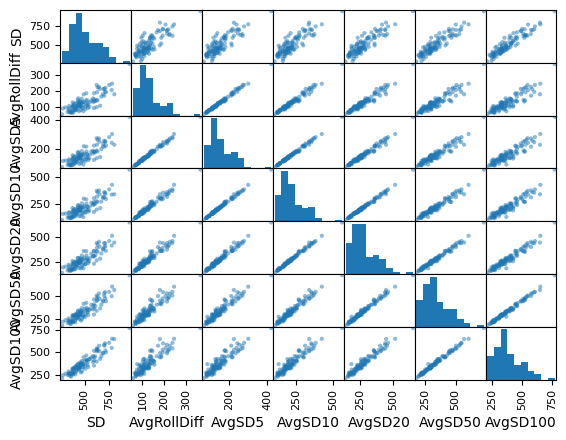

In [ ]:
pd.plotting.scatter_matrix(songs_num_cols)

In [ ]:
## Seperate pipelines for numeric vs. cat vars
num_transformer = Pipeline([("scaler", StandardScaler()),
                            ("transformer", PowerTransformer()),
                            ("reducer", PCA())])
cat_transformer = Pipeline([("encoder", OneHotEncoder(sparse=False, handle_unknown='ignore'))])

## Preprocessing transformer allowing different actions for numeric and categorical vars
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_col_names),
    ('cat', cat_transformer, cat_col_names)
])

# **Baseline Accuracy**

In [ ]:
print("Baseline accuracy: ", len(train[train["Tonal"] == 0]) / len(train))

Baseline accuracy:  0.56


# **KNN**

In [ ]:
pipe_knn = Pipeline([
    ("preprocessor", preprocessor),
    ("model", KNeighborsClassifier(n_neighbors = 15, weights='distance'))
])

parms_knn = {'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
             'preprocessor__num__reducer__n_components': [1, 2, 3, 4, 5, 6, 7],
             'model__n_neighbors': [5, 10, 15, 20],
             'model__weights': ['uniform', 'distance']}

grid_res_knn = GridSearchCV(pipe_knn, parms_knn, cv = 5, scoring = 'accuracy').fit(train_X, train_y)
pd.DataFrame(grid_res_knn.cv_results_).sort_values('mean_test_score', ascending=False)[
    ['param_preprocessor__num__scaler',
     'param_preprocessor__num__reducer__n_components',
     'param_model__n_neighbors',
     'param_model__weights',
     'mean_test_score']].head(5)

,param_preprocessor__num__scaler,param_preprocessor__num__reducer__n_components,param_model__n_neighbors,param_model__weights,mean_test_score
137,MinMaxScaler(),4,20,uniform,0.58
143,MinMaxScaler(),6,20,uniform,0.58
140,MinMaxScaler(),5,20,uniform,0.58
146,MinMaxScaler(),7,20,uniform,0.58
136,RobustScaler(),4,20,uniform,0.58


# **SVM**

In [ ]:
pipe_svm = Pipeline([
    ("preprocessor", preprocessor),
    ("model", SVC())
])

parms_svm = {'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
             'preprocessor__num__reducer__n_components': [1, 2, 3, 4, 5, 6, 7],
             'model__kernel': ['linear', 'poly', 'rbf'],
             'model__C': [10, 1, .1, .01]}

grid_res_svm = GridSearchCV(pipe_svm, parms_svm, cv = 5, scoring = 'accuracy').fit(train_X, train_y)
pd.DataFrame(grid_res_svm.cv_results_).sort_values('mean_test_score', ascending=False)[
    ['param_preprocessor__num__scaler',
     'param_preprocessor__num__reducer__n_components',
     'param_model__kernel',
     'param_model__C',
     'mean_test_score']].head(5)

,param_preprocessor__num__scaler,param_preprocessor__num__reducer__n_components,param_model__kernel,param_model__C,mean_test_score
4,RobustScaler(),2,linear,10,0.63
5,MinMaxScaler(),2,linear,10,0.63
6,StandardScaler(),3,linear,10,0.62
7,RobustScaler(),3,linear,10,0.62
8,MinMaxScaler(),3,linear,10,0.62


# **Logistic Regression**

In [ ]:
pipe_log = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression())
])

parms_log = {'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
              'preprocessor__num__reducer__n_components': [1, 2, 3, 4, 5, 6, 7],
              'model': [LogisticRegression(penalty = None, solver = "newton-cg"),
                        LogisticRegression(penalty = "l2", solver = "newton-cg"),
                        LogisticRegression(penalty = "l2", solver = "liblinear"),
                        LogisticRegression(penalty = "l1", solver = "liblinear"),
                        ]}

grid_res_log = GridSearchCV(pipe_log, parms_log, cv = 5, scoring = 'accuracy').fit(train_X, train_y)
pd.DataFrame(grid_res_log.cv_results_).sort_values('mean_test_score', ascending=False)[
    ['param_preprocessor__num__scaler',
     'param_preprocessor__num__reducer__n_components',
     'param_model',
     'mean_test_score']].head(5)

,param_preprocessor__num__scaler,param_preprocessor__num__reducer__n_components,param_model,mean_test_score
83,MinMaxScaler(),7,"LogisticRegression(penalty='l1', solver='libli...",0.65
81,StandardScaler(),7,"LogisticRegression(penalty='l1', solver='libli...",0.65
73,RobustScaler(),4,"LogisticRegression(penalty='l1', solver='libli...",0.65
72,StandardScaler(),4,"LogisticRegression(penalty='l1', solver='libli...",0.65
71,MinMaxScaler(),3,"LogisticRegression(penalty='l1', solver='libli...",0.65


# **MLP**

In [ ]:
pipe_mlp = Pipeline([
    ("preprocessor", preprocessor),
    ("model", MLPClassifier(hidden_layer_sizes=(4,), activation='logistic', solver='lbfgs', learning_rate='constant', learning_rate_init=0.1, max_iter=1000))
])

parms_mlp = {'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
             'preprocessor__num__reducer__n_components': [1, 2, 3, 4, 5, 6, 7],
             "model__hidden_layer_sizes": [(3,), (4,), (5,)],
             "model__batch_size": [10, 15, 20, 25]}

grid_res_mlp = GridSearchCV(pipe_mlp, parms_mlp, cv = 5, scoring = 'accuracy').fit(train_X, train_y)
pd.DataFrame(grid_res_mlp.cv_results_).sort_values('mean_test_score', ascending=False)[
    ['param_preprocessor__num__scaler',
     'param_preprocessor__num__reducer__n_components',
     'param_model__hidden_layer_sizes',
     'param_model__batch_size',
     'mean_test_score']].head(5)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

,param_preprocessor__num__scaler,param_preprocessor__num__reducer__n_components,param_model__hidden_layer_sizes,param_model__batch_size,mean_test_score
13,RobustScaler(),5,"(3,)",10,0.65
234,StandardScaler(),2,"(5,)",25,0.65
18,StandardScaler(),7,"(3,)",10,0.64
139,RobustScaler(),5,"(3,)",20,0.64
125,MinMaxScaler(),7,"(5,)",15,0.63


# **XGBoost**

In [ ]:
import xgboost as xgb

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("model", xgb.XGBClassifier(eval_metric='error', use_label_encoder=False))
])
parms_xgb = {'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
             'preprocessor__num__reducer__n_components': [1, 2, 3, 4, 5, 6, 7],
             'model__learning_rate': [.01, .1, .2, .5],
             'model__max_depth': [1, 2, 3, 4]}

grid_res_xgb = GridSearchCV(pipe_xgb, parms_xgb, cv=5, scoring = 'accuracy').fit(train_X, train_y)
pd.DataFrame(grid_res_xgb.cv_results_).sort_values('mean_test_score', ascending=False)[
    ['param_preprocessor__num__scaler',
     'param_preprocessor__num__reducer__n_components',
     'param_model__learning_rate',
     'param_model__max_depth',
     'mean_test_score']].head(5)

,param_preprocessor__num__scaler,param_preprocessor__num__reducer__n_components,param_model__learning_rate,param_model__max_depth,mean_test_score
23,MinMaxScaler(),1,0.01,2,0.64
22,RobustScaler(),1,0.01,2,0.64
21,StandardScaler(),1,0.01,2,0.64
84,StandardScaler(),1,0.1,1,0.64
85,RobustScaler(),1,0.1,1,0.64


# **Decision Tree**

In [ ]:
pipe_tree = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier())
])

parms_tree = {'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
              'preprocessor__num__reducer__n_components': [1, 2, 3, 4, 5, 6, 7],
              'model__max_depth': [2, 3, 4],
              'model__min_samples_split': [5, 10, 15, 20]}

grid_res_tree = GridSearchCV(pipe_tree, parms_tree, cv = 5, scoring = 'accuracy').fit(train_X, train_y)
pd.DataFrame(grid_res_tree.cv_results_).sort_values('mean_test_score', ascending=False)[
    ['param_preprocessor__num__scaler',
     'param_preprocessor__num__reducer__n_components',
     'param_model__max_depth',
     'param_model__min_samples_split',
     'mean_test_score']].head(5)

,param_preprocessor__num__scaler,param_preprocessor__num__reducer__n_components,param_model__max_depth,param_model__min_samples_split,mean_test_score
108,StandardScaler(),2,3,10,0.63
109,RobustScaler(),2,3,10,0.63
110,MinMaxScaler(),2,3,10,0.62
2,MinMaxScaler(),1,2,5,0.62
22,RobustScaler(),1,2,10,0.62


# **Random Forest**

In [ ]:
pipe_forest = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier())
])

parms_forest = {'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
                'preprocessor__num__reducer__n_components': [1, 2, 3],
                "model__max_depth": [2, 3],
                "model__min_samples_split": [5, 10, 15],
                "model__max_features": [2, 3, 4],
                "model__n_estimators": [30, 50, 70]}

grid_res_forest = GridSearchCV(pipe_forest, parms_forest, cv = 5, scoring = 'accuracy').fit(train_X, train_y)
pd.DataFrame(grid_res_forest.cv_results_).sort_values('mean_test_score', ascending=False)[
    ['param_preprocessor__num__scaler',
     'param_preprocessor__num__reducer__n_components',
     'param_model__max_depth',
     'param_model__min_samples_split',
     'param_model__max_features',
     'param_model__n_estimators',
     'mean_test_score']].head(5)

,param_preprocessor__num__scaler,param_preprocessor__num__reducer__n_components,param_model__max_depth,param_model__min_samples_split,param_model__max_features,param_model__n_estimators,mean_test_score
279,StandardScaler(),1,3,10,2,50,0.67
378,StandardScaler(),1,3,15,3,30,0.66
461,MinMaxScaler(),1,3,15,4,30,0.66
460,RobustScaler(),1,3,15,4,30,0.65
370,RobustScaler(),1,3,10,3,70,0.65


# **Compare 7 Models**

In [ ]:
pipe_7 = Pipeline([
    ("model", KNeighborsClassifier())
])

parms_7 = {"model": [grid_res_knn.best_estimator_,
                     grid_res_svm.best_estimator_,
                     grid_res_log.best_estimator_,
                     grid_res_mlp.best_estimator_,
                     grid_res_xgb.best_estimator_,
                     grid_res_tree.best_estimator_,
                     grid_res_forest.best_estimator_]}

grid_res_7 = GridSearchCV(pipe_7, parms_7, cv = 5, scoring = 'accuracy').fit(train_X, train_y)
pd.DataFrame(grid_res_7.cv_results_).sort_values('mean_test_score', ascending=False)[
    ['param_model',
     'mean_test_score']]

,param_model,mean_test_score
2,"(ColumnTransformer(transformers=[('num',\n ...",0.65
4,"(ColumnTransformer(transformers=[('num',\n ...",0.64
1,"(ColumnTransformer(transformers=[('num',\n ...",0.63
5,"(ColumnTransformer(transformers=[('num',\n ...",0.60
0,"(ColumnTransformer(transformers=[('num',\n ...",0.58
3,"(ColumnTransformer(transformers=[('num',\n ...",0.58
6,"(ColumnTransformer(transformers=[('num',\n ...",0.56


**The best-performing models on the training set are Logistic Regression, XGBoost, and SVM, with the cross-validated training accuracies of 0.65, 0.64, and 0.63, respectively.**

# **Ensemble**

In [ ]:
## Defining the individual models
model1 = grid_res_log.best_estimator_
model2 = grid_res_xgb.best_estimator_
model3 = grid_res_svm.best_estimator_

## Create the ensemble
my_ensemble = VotingClassifier(estimators=[('log', model1), ('xgb', model2), ('svm', model2)], voting='hard', weights=[1, 1, 1])

## Some tuning parameters to search over
parms_ensemble = {'voting': ['soft', 'hard'],
                  'weights': [[1, 1, .8], [1, .8, 1], [.8, 1, 1], [1, 1, .6], [1, .6, 1], [.6, 1, 1], [.6, .8, 1], [.8, .6, 1], [.6, 1, .8], [.8, 1, .6], [1, .6, .8], [1, .8, .6]]}

grid_res_ensemble = GridSearchCV(my_ensemble, parms_ensemble, cv=5, scoring = 'accuracy').fit(train_X, train_y)
pd.DataFrame(grid_res_ensemble.cv_results_).sort_values('mean_test_score', ascending=False)[['param_voting', 'param_weights', 'mean_test_score']]

,param_voting,param_weights,mean_test_score
12,hard,"[1, 1, 0.8]",0.64
13,hard,"[1, 0.8, 1]",0.64
22,hard,"[1, 0.6, 0.8]",0.64
21,hard,"[0.8, 1, 0.6]",0.64
20,hard,"[0.6, 1, 0.8]",0.64
19,hard,"[0.8, 0.6, 1]",0.64
18,hard,"[0.6, 0.8, 1]",0.64
17,hard,"[0.6, 1, 1]",0.64
16,hard,"[1, 0.6, 1]",0.64
15,hard,"[1, 1, 0.6]",0.64


# **Compare 8 Model/Ensemble**

In [ ]:
pipe_8 = Pipeline([
    ("model", KNeighborsClassifier())
])

parms_8 = {"model": [grid_res_knn.best_estimator_,
                     grid_res_svm.best_estimator_,
                     grid_res_log.best_estimator_,
                     grid_res_mlp.best_estimator_,
                     grid_res_xgb.best_estimator_,
                     grid_res_tree.best_estimator_,
                     grid_res_forest.best_estimator_,
                     grid_res_ensemble.best_estimator_]}

grid_res_8 = GridSearchCV(pipe_8, parms_8, cv = 5, scoring = 'accuracy').fit(train_X, train_y)
pd.DataFrame(grid_res_8.cv_results_).sort_values('mean_test_score', ascending=False)[
    ['param_model',
     'mean_test_score']]

,param_model,mean_test_score
2,"(ColumnTransformer(transformers=[('num',\n ...",0.65
4,"(ColumnTransformer(transformers=[('num',\n ...",0.64
1,"(ColumnTransformer(transformers=[('num',\n ...",0.63
7,"VotingClassifier(estimators=[('log',\n ...",0.63
5,"(ColumnTransformer(transformers=[('num',\n ...",0.62
6,"(ColumnTransformer(transformers=[('num',\n ...",0.60
0,"(ColumnTransformer(transformers=[('num',\n ...",0.58
3,"(ColumnTransformer(transformers=[('num',\n ...",0.50


In [ ]:
print(grid_res_8.best_estimator_)

Pipeline(steps=[('model',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler()),
                                                                                   ('transformer',
                                                                                    PowerTransformer()),
                                                                                   ('reducer',
                                                                                    PCA(n_components=3))]),
                                                                   ['SD',
                                                                    'AvgRollDiff',
                                                                    'AvgSD5',
           

**The best-performing model in the training set is Logistic Regression, with a cross-validated training accuracy of 0.65.**

# **Confusion Matrix**

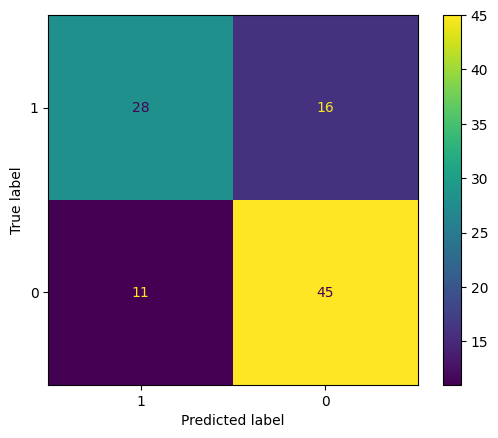

In [ ]:
## Display confusion matrix on training set
ConfusionMatrixDisplay.from_predictions(train_y, grid_res_8.predict(train_X), labels = [1, 0])
plt.show()

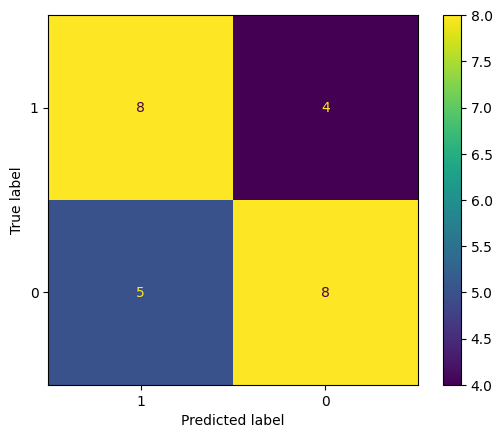

In [ ]:
## Display confusion matrix on test set
ConfusionMatrixDisplay.from_predictions(test_y, grid_res_8.predict(test_X), labels = [1, 0])
plt.show()

# **ROC AUC**

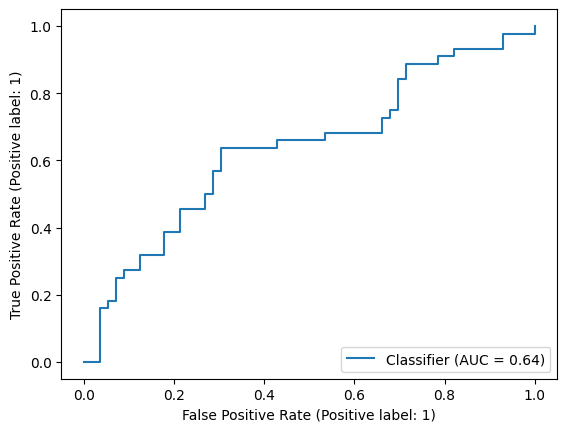

In [ ]:
train_y_pred_prob = cross_val_predict(estimator = grid_res_8.best_estimator_, X = train_X, y = train_y, cv = 5, method = 'predict_proba')

# ROC curve plotting:
RocCurveDisplay.from_predictions(train_y, train_y_pred_prob[:,1])
plt.show()

# **Testing Accuracy**

In [ ]:
print("Accuracy on the test set: ", accuracy_score(test_y, grid_res_8.predict(test_X)))

Accuracy on the test set:  0.64


**The model generalizes well to new data.**